In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
#from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
#from IPython.display import HTML
plt.style.use('ggplot')
%matplotlib inline


## Simulated 2-Class Data

This will be 2-normally distributed clusters. The data is not completely linearly separable but they have some separation. We pick a mean to center our "negative examples" around and a second mean to center our "positive examples". In this example the negative examples have a larger standard deviation.


In [3]:
samples = 1000

# Alwasy setting the seed
# so run is reproducible
data_seed = 42
np.random.seed(data_seed)

# 2D-mean of the negative then respectively positive cluster
classMeans = np.vstack([np.array([-1,1]),np.array([1,-1])])
# Std of the negative then respectively positive cluster
classStd = [0.75,.5]

# Coinflip to determine whether a sample is negative or positive
target = np.array([np.random.randint(0,2) for sample in range(samples)])
# Based on the class we pick the mean and add some normal random noise
inputFeatures = np.array([
            classMeans[label,:] + np.random.randn(2)*classStd[label] 
            for label in target])

df = pd.DataFrame({'x0':inputFeatures[:,0], 
                   'x1':inputFeatures[:,1],
                   'y': target, #numerical version
                   'target':(np.array(['Positive','Negative'])[target])})
df.head()


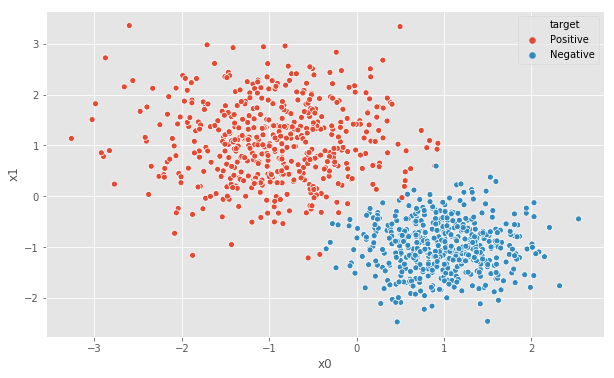

In [4]:
fig, ax = plt.subplots(1,figsize=(10,6))
_=sns.scatterplot(x='x0',y='x1',hue='target', data=df,ax=ax)

### Visualizing our Simulated Data

Note we use good matplotlib form here and avoid calling "plt" directly. This shows the two clusters. 

## Logistic Regression Classifier
![Perceptron](Perceptron.png)


We start out with a simple neural network which includes an input node for each of 2 dimensions $x_1, x_2$, and a single output node. In this network we have two weights $w_1,w_2$ corresponding to the input nodes, and a bias term $b$. The sigmoid activation is given by

$$f(z) = \frac{1}{1+e^{-z}}.$$

If we make vectors $\theta = (w_1, w_2, b)$ and $x = (x_1, x_2, 1)$ then we can write the prediction of a classifier determined by $\theta$ for input data $x$ is 

$$f_\theta(x) = \frac{1}{1+e^{-\theta^Tx}}$$

where $\theta^Tx$ is the dot product of $\theta$ and $x$, in other words $\theta^Tx = x_1w_1 + x_2 w_2 + b$. The prediction $f_\theta(x)$ is the classifiers estimate that $x$ is in the positive class. 

The key thing is to determine a good $\theta$ that estimates these probabilities well. We will learn the best $\theta$ using gradient decent. But to start lets just choose random values for $\theta$.

In [5]:
# logistic sigmoid activation
def sigmoid(z):
    """Logistic Sigmoid"""
    return (np.exp(z*(-1.0))+1)**(-1)

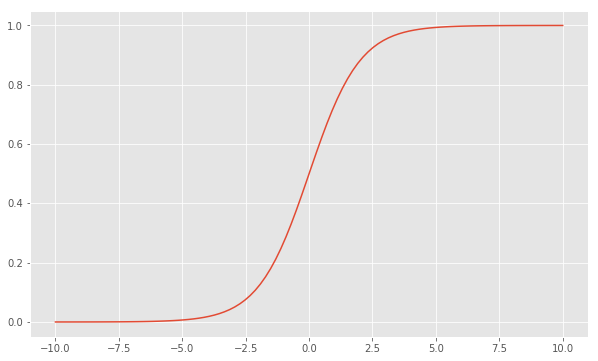

In [6]:
_, ax = plt.subplots(1,figsize=(10,6))
xaxis = np.linspace(-10,10,100)
_= ax.plot(xaxis,sigmoid(xaxis))

In [7]:
# Always seed when using random for reproducibility
seed = 56
np.random.seed(seed)

# Now we pick random weights and bias to start with
weights_0 = np.random.randn(2)
bias_0 = np.random.randn(1)

print(weights_0, bias_0)

[-1.03764318  0.59365816] [1.10268062]


In [8]:
# Feed Forward 
def predict(X, weights, bias):
    """Logistic Sigmoid Prediction"""
    return sigmoid(np.dot(X,weights)+ bias)

In [9]:
# Here we actually make predictions on the data X
# y_pred are the predicted probabilities of being postive
# y_pred = predict(X, weights, bias)
# Here we use 0.5 to threshold and make a decision that the label is positive
# y_pred_label = y_pred> 0.5

In [10]:
X=df[['x0','x1']]
df['p_prob'] = predict(X, weights_0, bias_0)
# Predict at greater than 0.5
df['p_label'] = predict(X, weights_0, bias_0)>0.5
df.head()

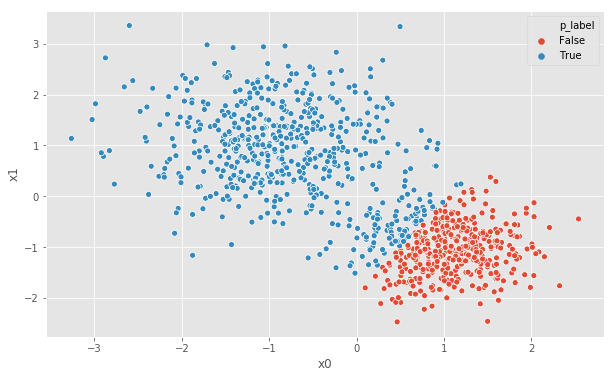

In [11]:
fig, ax = plt.subplots(1,figsize=(10,6))
_=sns.scatterplot(x='x0',y='x1',hue='p_label', data=df,ax=ax)

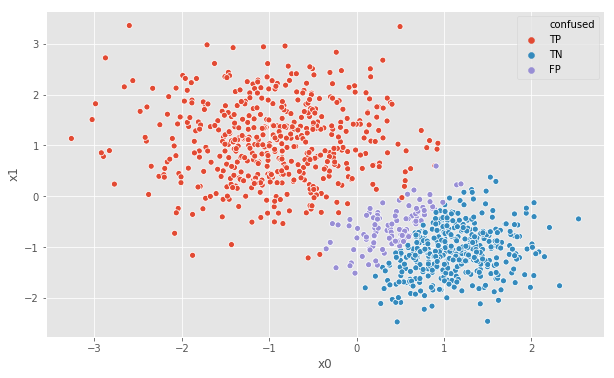

In [12]:
lab_table=np.array([['TN','FP'],['FN','TP']])
df['confused']=np.array([lab_table[int(target=='Positive'),int(p_label)] 
                for target, p_label in df[['target','p_label']].values])
fig, ax = plt.subplots(1,figsize=(10,6))
_=sns.scatterplot(x='x0',y='x1',hue='confused', data=df,ax=ax)

In [13]:
# We use a cross entropy loss. This is corresponds to asking what 
# is the probability that the data we see could have come from
# a distribution with the probabilites we predicted.
def cross_entropy_loss(y,y_pred):
    """Loss based on negative log-likelihood of the data.
    Target values passed in first.
    """
    loss=np.zeros(y.shape[0])
    loss[y==1]= - np.log(y_pred[y==1])
    loss[y!=1]= - np.log(1-y_pred[y!=1])
    return loss.mean()

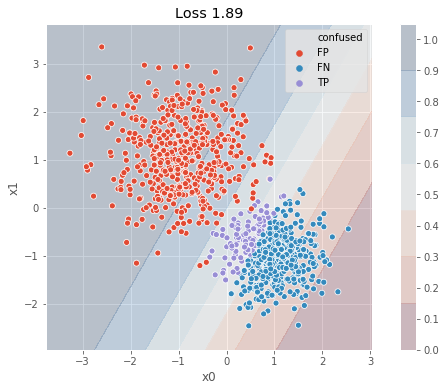

In [14]:
# This is an all-in-one function that goes from Data to visualization of
# prediction. Note you need to give it the weights and bias.

def show_classification(X,y,weights,bias):
    cm = plt.cm.RdBu
    bounds = np.arange(0,11)*0.1
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    x_min, x_max = X.values[:, 0].min() - .5, X.values[:, 0].max() + .5
    y_min, y_max = X.values[:, 1].min() - .5, X.values[:, 1].max() + .5
    h = .2 # step size in the mesh
    # This makes 2-D grids of x and respectively y coorindates
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))
    df_points = pd.DataFrame()
    df_points['x0']=X.values[:,0]
    df_points['x1']=X.values[:,1]
    df_points['y']=y
    df_points['p_prob']=predict(X, weights, bias)
    df_points['p_label']=df_points['p_prob']>0.5
    confused = np.array([lab_table[int(target),int(p_label)] 
                for target, p_label in df_points[['y','p_label']].values])
    df_points['confused']= confused
    #y_pred_label = y_pred> 0.5
    loss = cross_entropy_loss(y,df_points['p_prob'])
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title("Loss {:03.2f}".format(loss))
    Z = predict(np.c_[xx.ravel(),yy.ravel()], weights, bias)
    Z = Z.reshape(xx.shape)
    pcm = ax.contourf(xx,yy,Z,norm=norm, cmap=cm, alpha=.2)
    sns.scatterplot(x='x0',y='x1',hue='confused', data=df_points,ax=ax)
    ax.legend()
    ax.set_aspect('equal')
    fig.colorbar(pcm, ax=ax,ticks=bounds)
    plt.show()
    return fig, ax

y=(df['y']).values
# Lets see an example with the random weights we choose. 
_ = show_classification(X,y,weights_0,bias_0)

## Gradient Decent

We first compute the gradient of the loss with respect to the space of weight and bias parameters. To perform gradient decent we compute this gradient with respect to all the training examples.

In [15]:
def gradient(X, y, weights, bias):
    num_obs, num_feats = X.shape
    y_pred = predict(X, weights, bias)
    errors = (y_pred - y).reshape(num_obs,1)
    return np.hstack([(X*errors).mean(axis=0),np.array(errors.mean())])

Here we will compute one step of gradient decent using all training examples. Note the loss drops.

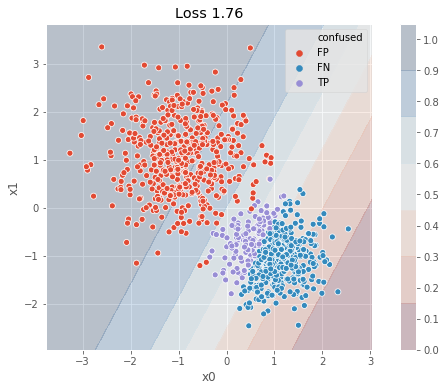

In [16]:
## Gradient with respect to all the training examples
grad = gradient(X.values, y, weights_0, bias_0)

learning_rate = 0.1
weights_1, bias_1 = (weights_0 - learning_rate*grad[:2], 
                     bias_0 - learning_rate*grad[2])
_ = show_classification(X,y,weights_1,bias_1)


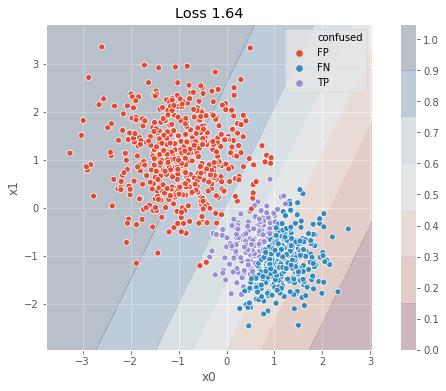

In [17]:
grad = gradient(X.values, y, weights_1, bias_1)

weights_2, bias_2 = (weights_1 - learning_rate*grad[:2], 
                     bias_1 - learning_rate*grad[2])
_ = show_classification(X,y,weights_2,bias_2)


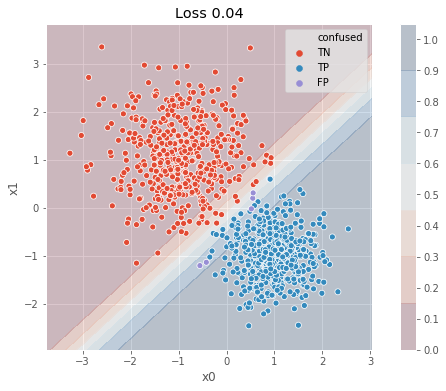

In [18]:
weights_n, bias_n = weights_1, bias_1
for _ in range(1000):
    grad = gradient(X.values, y, weights_n, bias_n)
    weights_n, bias_n = (weights_n - learning_rate*grad[:2], 
                         bias_n - learning_rate*grad[2])
_ = show_classification(X,y,weights_n,bias_n)